# Table of Contents
 <p><div class="lev1"><a href="#ChainerでVAEを書いてみる"><span class="toc-item-num">1&nbsp;&nbsp;</span>ChainerでVAEを書いてみる</a></div><div class="lev2"><a href="#GPU設定"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>GPU設定</a></div><div class="lev2"><a href="#MNISTデータのダウンロードといくつかプロットして確認"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>MNISTデータのダウンロードといくつかプロットして確認</a></div><div class="lev2"><a href="#パラメータの設定"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>パラメータの設定</a></div><div class="lev2"><a href="#モデルの定義"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>モデルの定義</a></div><div class="lev2"><a href="#VAEモデルとOptimizerを設定して学習の準備をする"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>VAEモデルとOptimizerを設定して学習の準備をする</a></div><div class="lev2"><a href="#学習の実施"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>学習の実施</a></div><div class="lev3"><a href="#結果の確認"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>結果の確認</a></div><div class="lev2"><a href="#中間層の状態を可視化する"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>中間層の状態を可視化する</a></div>

# ChainerでVAEを書いてみる
* 以下のページを参考に
  * https://github.com/RyotaKatoh/chainer-Variational-AutoEncoder
* VAEについては以下を参照した
  * http://papers.nips.cc/paper/5352-semi-supervised-learning-with-deep-generative-models.pdf
  * http://deeplearning.jp/wp-content/uploads/2014/04/dl_hacks2015-04-21-iwasawa1.pdf


In [15]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
import math

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import six

import matplotlib.pyplot as plt

# chainer exampleに付属のdata.pyをimportする. mnistのダウンロードのため
import data

## GPU設定

In [2]:
gpu_flag = 0
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## MNISTデータのダウンロードといくつかプロットして確認

In [3]:
# 手書き数字データを描画する関数
# 複数の画像配列になっているdata列を描画する
def draw_digit(data):
    size = 28
    n = data.shape[0]
    plt.figure(figsize=(n, 2))
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,27)
        plt.ylim(0,27)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

# いくつかプロット
def draw_digit_multi(data, n=10):
    # サンプラー
    indexes = np.random.permutation( len(data) )[:n]
    # 
    size = 28
    plt.figure(figsize=(15, 2))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

In [4]:
mnist = data.load_mnist_data()
# 70,000の手書き数字データ
# いくつかplotしてみる
#idxs = draw_digit_multi(mnist['data'])
#print "labels : "
#print mnist['target'][idxs]

# 正規化
mnist['data'] = mnist['data'].astype(np.float32)
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32)
# 訓練データとテストデータに分割
N = 60000
x_train, x_test = np.split(mnist['data'],   [N])
y_train, y_test = np.split(mnist['target'], [N])
N_test = y_test.size

## パラメータの設定

In [5]:
batchsize = 100 # ミニバッチのサイズ
n_epoch = 20     # epoch数
n_latent = 100   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
n_h = 500   # 隠れ層のサイズ
beta = 10   # KL正則化項の重み

# Optimizer
al = 0.001
b1 = 0.9
b2 = 0.999

## モデルの定義
* 公式exampleではnet.pyとして別ファイルになっている

In [6]:
class VAE(chainer.Chain):
    """Variational AutoEncoder"""
    def __init__(self, n_in, n_latent, n_h):
        super(VAE, self).__init__(
            ## ネットワーク構造の定義
            # encoder
            le1=L.Linear(n_in, n_h),
            le2_mu=L.Linear(n_h, n_latent),
            le2_ln_var=L.Linear(n_h, n_latent),
            # decoder
            ld1=L.Linear(n_latent, n_h),
            ld2=L.Linear(n_h, n_in),
        )

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        # 下記、encodeとdecodeの中身をこの中に書いても良いがencodeとｄｅｃｏｄｅは他でも使うので再利用性を高めるために
        return self.decode(self.encode(x)[0], sigmoid)
    
    def encode(self, x):
        # 推論モデル, 中間表現のベクトルqを学習
        h1 = F.tanh(self.le1(x))
        mu = self.le2_mu(h1)
        ln_var = self.le2_ln_var(h1)  # log(sigma**2)
        return mu, ln_var

    def decode(self, z, sigmoid=True):
        # 中間表現ベクトルqを入力として(z), 画像を生成
        h1 = F.tanh(self.ld1(z))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C=1.0, k=1, train=True):
        """Get loss function of VAE.
        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
            train (bool): If true loss_function is used for training.
        """
        def lf(x):
            mu, ln_var = self.encode(x)
            batchsize = len(mu.data)
            # reconstruction loss
            rec_loss = 0
            for l in six.moves.range(k):
                z = F.gaussian(mu, ln_var)
                rec_loss += F.bernoulli_nll(x, self.decode(z, sigmoid=False)) / (k * batchsize)
            self.rec_loss = rec_loss
            self.loss = self.rec_loss + C * gaussian_kl_divergence(mu, ln_var) / batchsize
            return self.loss
        return lf

## VAEモデルとOptimizerを設定して学習の準備をする

In [7]:
# モデルの設定
model = VAE(784, n_latent, n_h) # VAE(n_in, n_latent, n_h)  input=28*28=784
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Optimizerを定義する
optimizer = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
optimizer.setup(model)

## 学習の実施

In [9]:
loss_arr = []
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N)
    ## lossのbuffer
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    ## バッチ学習
    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        # optimizerのupdateメソッドにloss関数とデータを与える　こうすると中でいろいろやってくれる
        #optimizer.update(model.get_loss_func(), x)
        # 勾配を明示的に計算する場合
        model.zerograds()
        loss = model.get_loss_func(C=beta)(x)
        loss.backward()
        optimizer.update()
        
        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)

    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / N, sum_rec_loss / N))
    loss_arr.append(float(sum_loss)/N)

('epoch', 1)
train mean loss=241.800509211, mean reconstruction loss=211.639551519
('epoch', 2)
train mean loss=200.679645767, mean reconstruction loss=185.016245372
('epoch', 3)
train mean loss=198.510332158, mean reconstruction loss=180.811910528
('epoch', 4)
train mean loss=196.693086344, mean reconstruction loss=176.669071579
('epoch', 5)
train mean loss=194.58280337, mean reconstruction loss=172.672023315
('epoch', 6)
train mean loss=192.440561752, mean reconstruction loss=168.215877686
('epoch', 7)
train mean loss=190.831831589, mean reconstruction loss=164.706989263
('epoch', 8)
train mean loss=189.669399821, mean reconstruction loss=161.925787633
('epoch', 9)
train mean loss=188.5818396, mean reconstruction loss=159.511359762
('epoch', 10)
train mean loss=187.873418147, mean reconstruction loss=157.755916189
('epoch', 11)
train mean loss=187.285814768, mean reconstruction loss=156.216956228
('epoch', 12)
train mean loss=186.733291906, mean reconstruction loss=154.960248286
('ep

### 結果の確認

[]

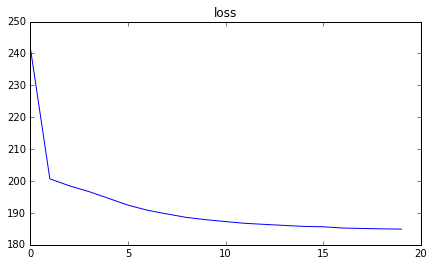

In [10]:
## lossグラフ
plt.figure(figsize=(7,4))
plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF")
plt.title("loss")
plt.plot()

training image


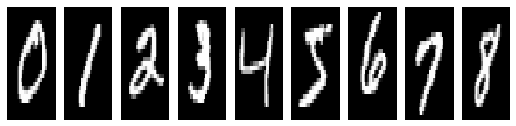

reconstruction image


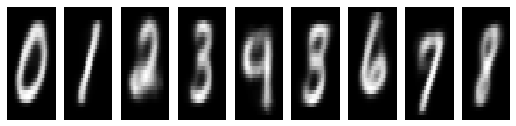

In [11]:
train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
x = chainer.Variable(xp.asarray(x_train[train_ind]), volatile='on')
x1 = model(x)

print "training image"
draw_digit(x_train[train_ind])

print "reconstruction image"
draw_digit(x1.data.get())


decode image from random vector


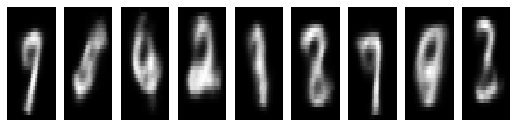

In [12]:
# draw images from randomly sampled z
z = chainer.Variable(xp.random.normal(0, 1, (9, n_latent)).astype(np.float32))
x = model.decode(z)
#draw_digit(x.data)
print "decode image from random vector"
draw_digit(x.data.get())

## 中間層の状態を可視化する

In [13]:
# 中間層の状態をプロットする
def draw_weight(data, size=28, N=100):
    # サンプラー
    n = N
    n_col = int(math.ceil(N / 10))
    indexes = np.random.permutation( len(data) )[:n]
    size = size
    plt.figure(figsize=(10*2, n_col*2))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(n_col, 10, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.title("{0}".format(idx), size=9)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

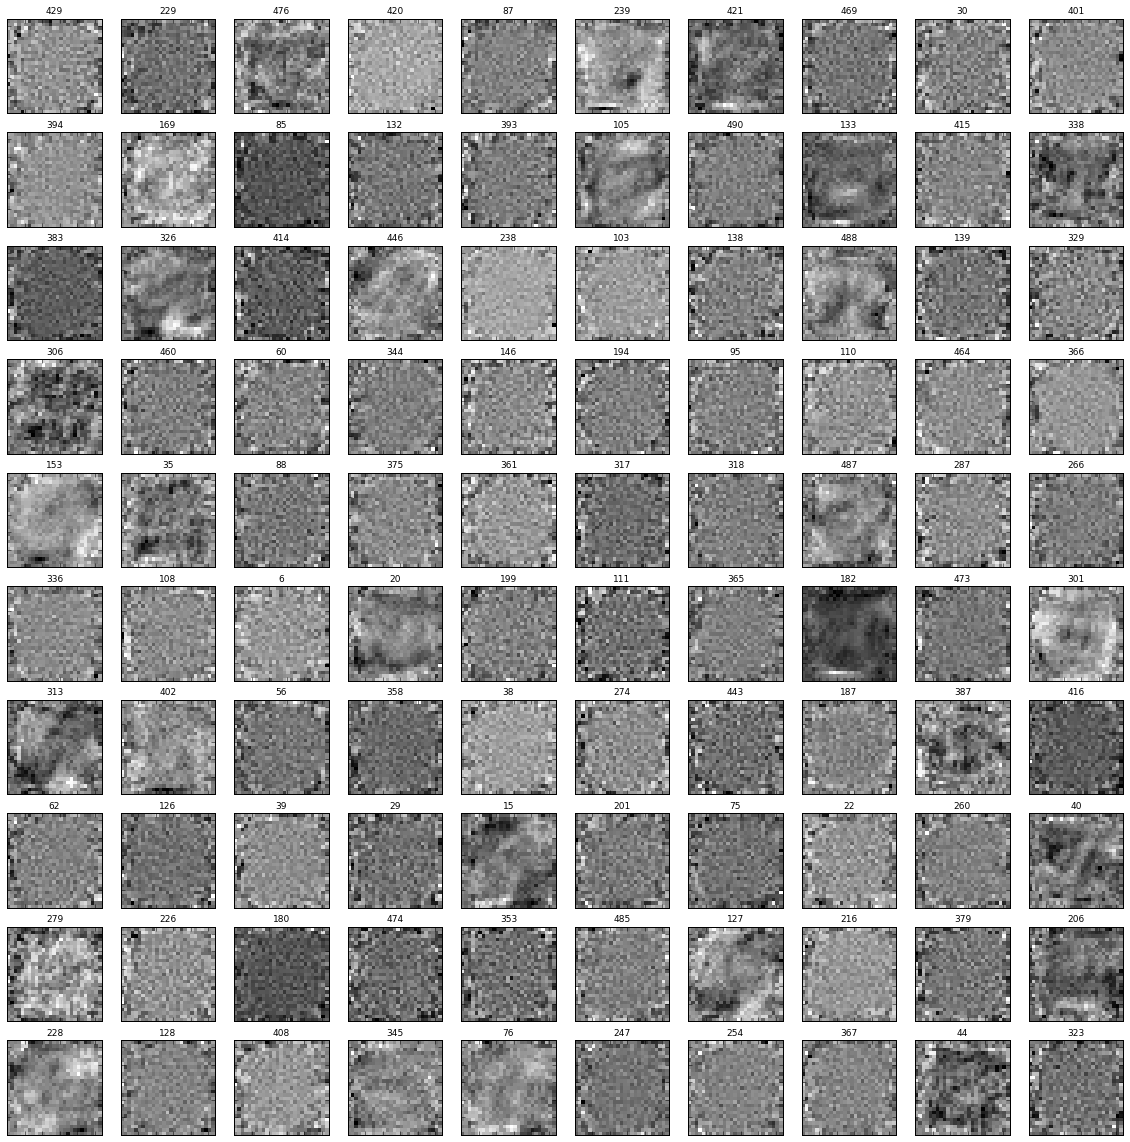

In [16]:
idxs = draw_weight(model.le1.W.data.get())

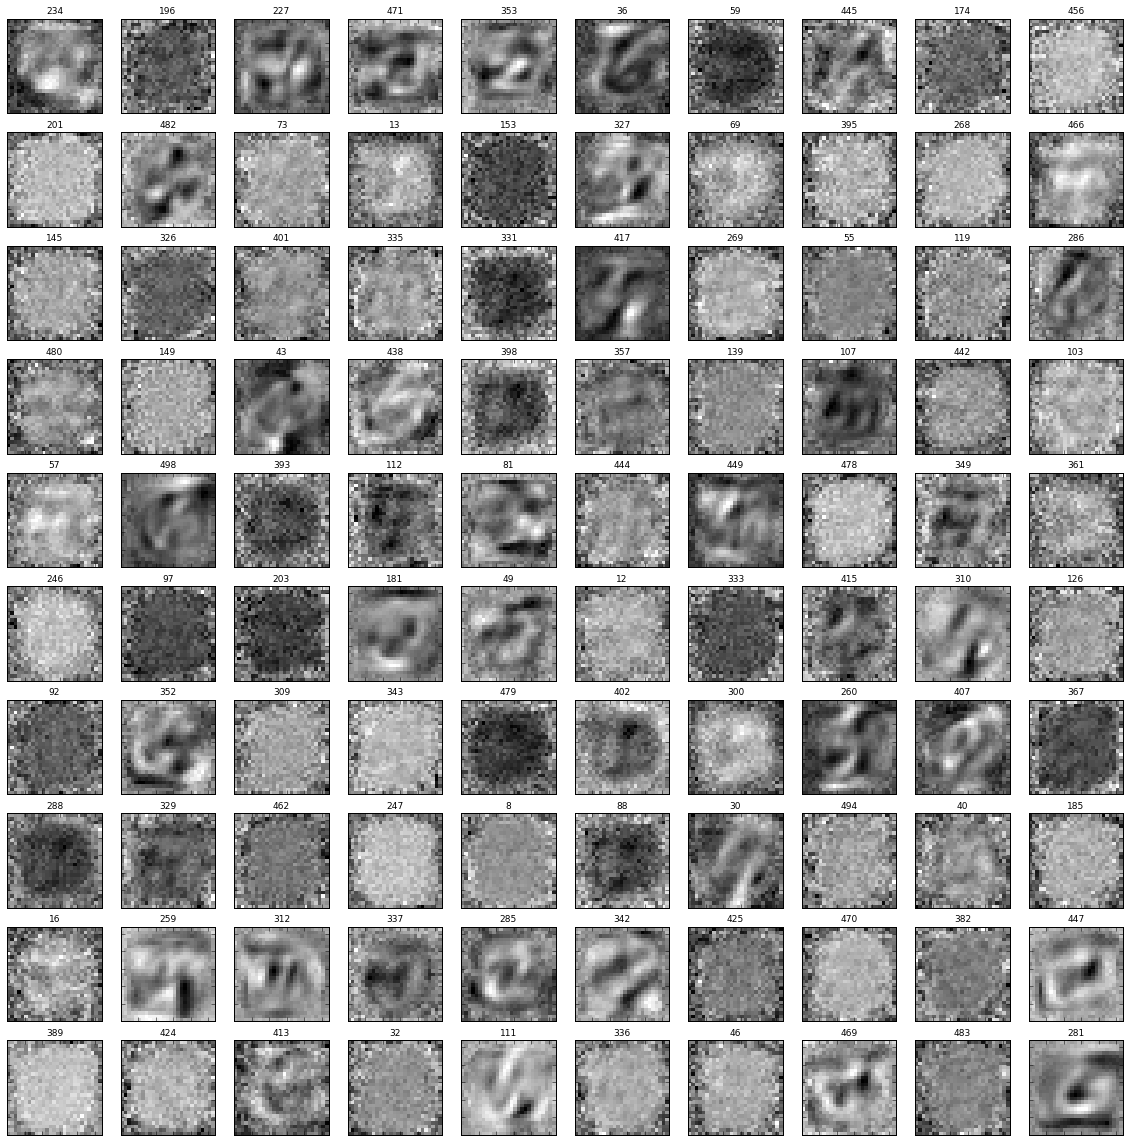

In [17]:
# 出力層の手前
idx = draw_weight(model.ld2.W.data.get().T)